<a href="https://colab.research.google.com/github/petroschalas/steinmetz_dataset_chalas/blob/master/Analysis_of_Steinmetz_et_al_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from matplotlib import rcParams 
from matplotlib import pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [30]:
#Helper Function
def plot_weights(models, sharey=True):
  """Draw a stem plot of weights for each model in models dict."""
  n = len(models)
  f = plt.figure(figsize=(10, 2.5 * n))
  axs = f.subplots(n, sharex=True, sharey=sharey)
  axs = np.atleast_1d(axs)

  for ax, (title, model) in zip(axs, models.items()):

    ax.margins(x=.02)
    stem = ax.stem(model.coef_.squeeze(), use_line_collection=True)
    stem[0].set_marker(".")
    stem[0].set_color(".2")
    stem[1].set_linewidths(.5)
    stem[1].set_color(".2")
    stem[2].set_visible(False)
    ax.axhline(0, color="C3", lw=3)
    ax.set(ylabel="Weight", title=title)
  ax.set(xlabel="Neuron (a.k.a. feature)")
  f.tight_layout()


def plot_function(f, name, var, points=(-10, 10)):
    """Evaluate f() on linear space between points and plot.

    Args:
      f (callable): function that maps scalar -> scalar
      name (string): Function name for axis labels
      var (string): Variable name for axis labels.
      points (tuple): Args for np.linspace to create eval grid.
    """
    x = np.linspace(*points)
    ax = plt.figure().subplots()
    ax.plot(x, f(x))
    ax.set(
      xlabel=f'${var}$',
      ylabel=f'${name}({var})$'
    )


def plot_model_selection(C_values, accuracies):
  """Plot the accuracy curve over log-spaced C values."""
  ax = plt.figure().subplots()
  ax.set_xscale("log")
  ax.plot(C_values, accuracies, marker="o")
  best_C = C_values[np.argmax(accuracies)]
  ax.set(
      xticks=C_values,
      xlabel="$C$",
      ylabel="Cross-validated accuracy",
      title=f"Best C: {best_C:1g} ({np.max(accuracies):.2%})",
  )

def plot_non_zero_coefs(C_values, non_zero_l1, n_voxels):
  """Plot the accuracy curve over log-spaced C values."""
  ax = plt.figure().subplots()
  ax.set_xscale("log")
  ax.plot(C_values, non_zero_l1, marker="o")
  ax.set(
    xticks=C_values,
    xlabel="$C$",
    ylabel="Number of non-zero coefficients",
  )
  ax.axhline(n_voxels, color=".1", linestyle=":")
  ax.annotate("Total\n# Neurons", (C_values[0], n_voxels * .98), va="top")

In [2]:
rcParams['figure.figsize'] = [18, 5]
rcParams['font.size'] =14
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [3]:
#Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)


In [4]:
#data loading
alldata = np.array([])
for j in range(len(fname)):
  alldata = np.hstack((alldata, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

In [5]:
#Fields available for every session
dat11=alldata[11]
print(dat11.keys())

dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])


In [6]:
# Available recordings from brain areas in each session
c=np.arange(0, 39, 1)

for i in c:
  datt = alldata[i]
  list_brain_areas = list(dict.fromkeys(datt['brain_area']))
  print("Session", i+1, ".", "Areas available:", list_brain_areas)

Session 1 . Areas available: ['ACA', 'MOs', 'LS', 'root', 'VISp', 'CA3', 'SUB', 'DG']
Session 2 . Areas available: ['CA1', 'VISl', 'root', 'VISpm', 'POST']
Session 3 . Areas available: ['DG', 'VISam', 'MG', 'CA1', 'SPF', 'root', 'LP', 'MRN', 'POST', 'NB', 'VISp']
Session 4 . Areas available: ['LGd', 'DG', 'TH', 'SUB', 'VPL', 'VISp', 'CA1', 'VISa', 'LSr', 'ACA', 'MOs']
Session 5 . Areas available: ['VISa', 'root', 'CA1', 'SUB', 'DG', 'OLF', 'ORB', 'ACA', 'PL', 'MOs']
Session 6 . Areas available: ['AUD', 'root', 'SSp', 'CA1', 'TH']
Session 7 . Areas available: ['VPL', 'root', 'CA3', 'LD', 'CP', 'EPd', 'SSp', 'PIR']
Session 8 . Areas available: ['ILA', 'TT', 'MOs', 'PL', 'LSr', 'root', 'LD', 'PO', 'CA3', 'VISa', 'CA1', 'LP', 'DG', 'VISp', 'SUB']
Session 9 . Areas available: ['TT', 'ORBm', 'PL', 'LSr', 'root', 'CA3', 'VISl', 'CA1', 'TH', 'VISam', 'VPL', 'LD']
Session 10 . Areas available: ['MB', 'VISp', 'SCm', 'SCsg', 'POST', 'DG', 'MRN', 'CA1', 'VISl', 'POL', 'root', 'GPe', 'VISrl']
Sessi

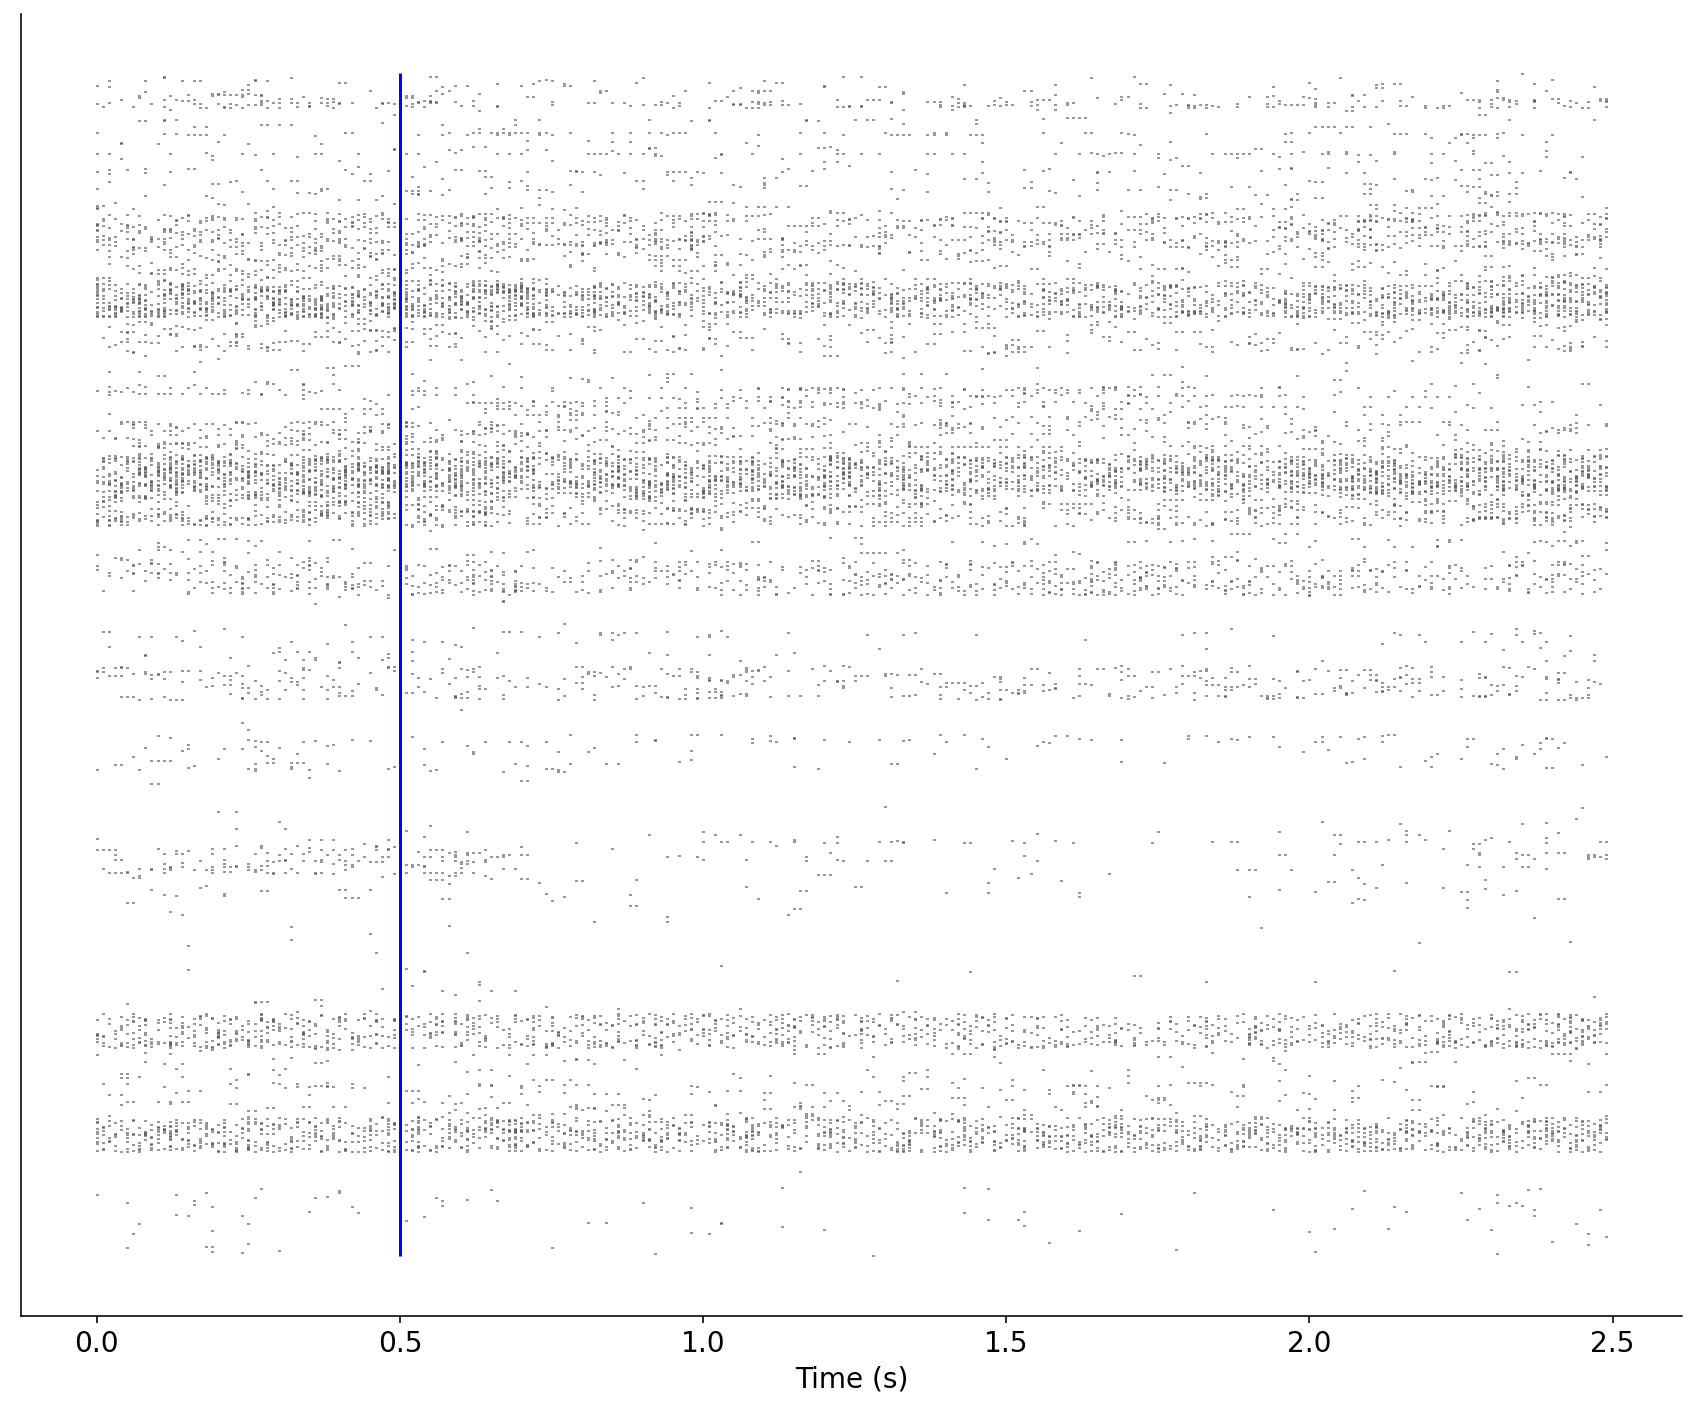

In [38]:
# Find the raster plot for certain brain areas, for certain session, all neurons and trials


def raster_everything(session, raster_area):
  dat = alldata[session-1]
  area = dat['brain_area'] #take all the brain areas from session 1
  ind_area = np.where(area==raster_area)[0] #indices for CA1
  spikes = dat['spks'] 
  trials = spikes[0,:,0]
  ind_trial = np.arange(0, len(trials)) #an array with the number of trials
  
  time = np.arange(0,dat['spks'].shape[-1] * 0.01 ,0.01)
  spike_times = []

  for j in ind_area:
    for i in ind_trial:
      neuron_spikes = dat['spks'][j,i,:]
  
      indexes = np.where(neuron_spikes == 1)[0]
    
      spike_times.append([time[k] for k in indexes])
 
  plt.eventplot((spike_times), color=".2")
  plt.xlabel("Time (s)")
  plt.yticks([]);
  plt.vlines(0.5, 0, len(spike_times), colors='b') #stimulus presentation

# Example for dat['brain_area'] = 'DG'
raster_everything(3,'DG')


In [8]:
#A function that creates a peri-stimulus time histogram, 0.5 sec before and after stimulus presentation

def psth_feedback(session, area, feedback):
  dat = alldata[session-1]
  plusone_indx = np.where(dat['feedback_type'] == feedback)[0]


  #Time = 2,5 second divided by 10ms bins
  time = np.arange(0,dat['spks'].shape[-1] * 0.01 ,0.01) 
  spike_times_plusone_area = []
  ind_area = np.where(dat['brain_area']==area)[0] #indices for brain area
  for x in plusone_indx:
    neurons_plusone_area = dat['spks'][ind_area,x,0:101]
    for j in neurons_plusone_area:
      #Spikes_indexes_plusone_area indexes of spikes in neurons with +1 feedback
      spikes_indexes_plusone_area = np.where(j == 1)[0]
      spike_times_plusone_area.append([time[k] for k in spikes_indexes_plusone_area])
      spike_times_plusone_area = [x for x in spike_times_plusone_area if x != []]      
      
  
  plt.figure()
  psthspks = []
  for x in spike_times_plusone_area:
    for j in x:
      psthspks.append(j)
  y, x, _ = plt.hist(psthspks, 50,range=[0,1], color='c')
  plt.vlines(0.5, 0, y.max(),  colors='r', linestyles='dashdot')
  plt.rcParams["figure.figsize"] = (12,10)
  
 

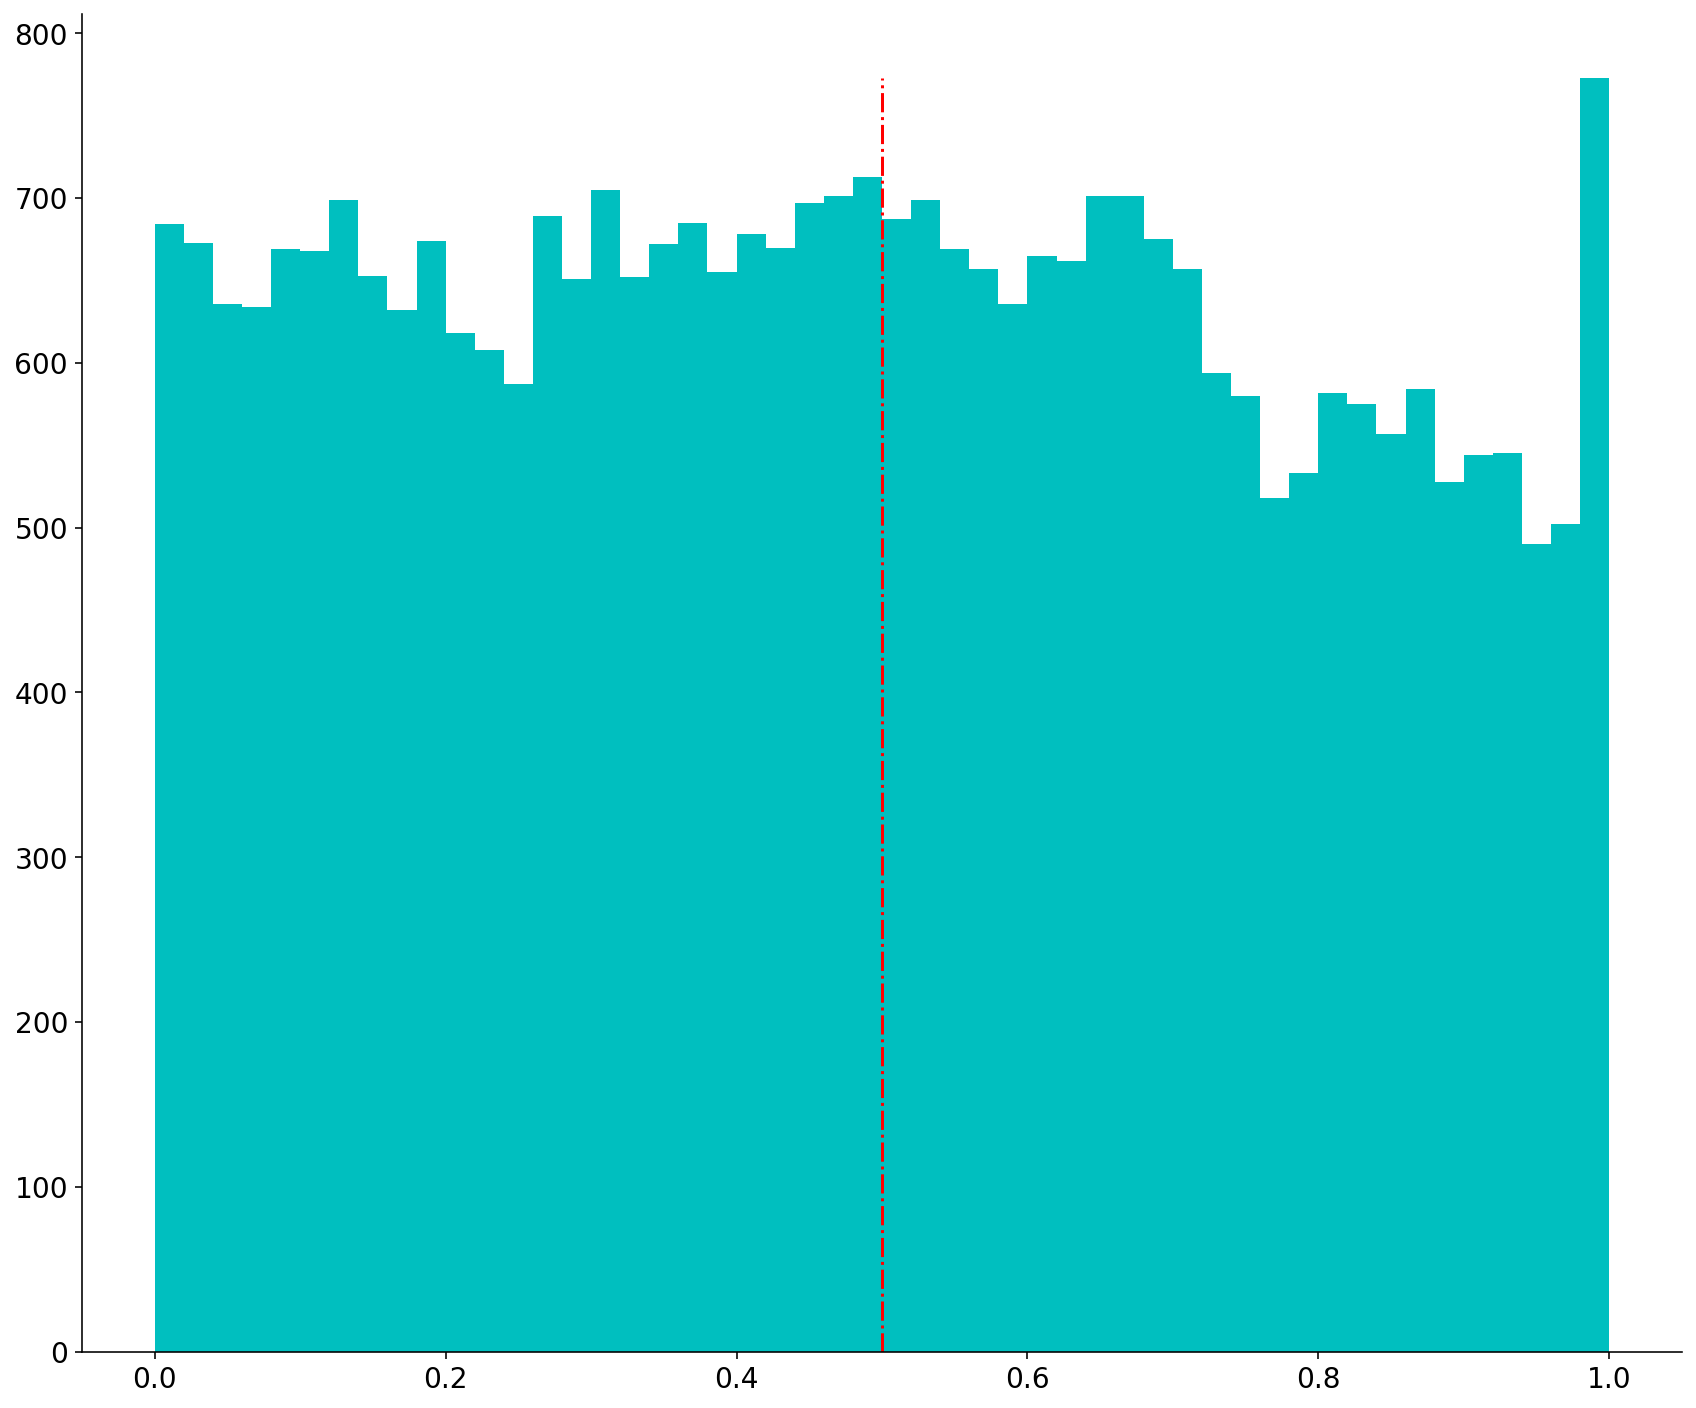

In [39]:
psth_feedback(3, 'DG', +1)

In [18]:
#Firing rates pre stimulus and after stimulus presentation for certain area, session

def firing_rate(session, firing_area):
  
  dat=alldata[session-1]
  area = dat['brain_area'] #take all the brain areas from desired session
  ind_area = np.where(area==firing_area)[0] #indices for CA1
  ind_trials=np.arange(0,dat['spks'].shape[1],1)
  ind_neurons=np.arange(0,dat['spks'].shape[0],1)
  time = np.arange(0,dat['spks'].shape[-1]* 0.01 ,0.01)
  plusoneindex=np.where(dat['feedback_type']==+1.0)[0]
  X=np.zeros((len(ind_neurons),len(ind_trials)))
  for i in ind_neurons:
   for j in ind_trials:
    spikes_pre = dat['spks'][i,j,:50]
    overallspikes_pr=np.sum(spikes_pre)
    FRpre=overallspikes_pr/0.5   
    gocue_index=np.argmin(abs(time-dat['gocue'][j]))
    spikes_as = dat['spks'][i,j, 51:gocue_index+50]
    overallspikes_as=np.sum(spikes_as)
    FRafter=overallspikes_as/(len(spikes_as)*0.01)              

    X[i,j]=FRafter-FRpre  
  return X

In [40]:
#GLM
dat3=alldata[2]
X_T=np.transpose(firing_rate(3,'DG'))
w=dat0['feedback_type']
minusoneindex=np.where(w==-1)[0]
plusoneindex=np.where(w==+1)[0]

X_TGL=np.vstack((X_T[minusoneindex,:],X_T[plusoneindex,:]))    #neuronsindex
y=np.concatenate((w[minusoneindex],w[plusoneindex]))
print(X_TGL.shape)
print(y.shape)

(214, 1769)
(214,)


1.0


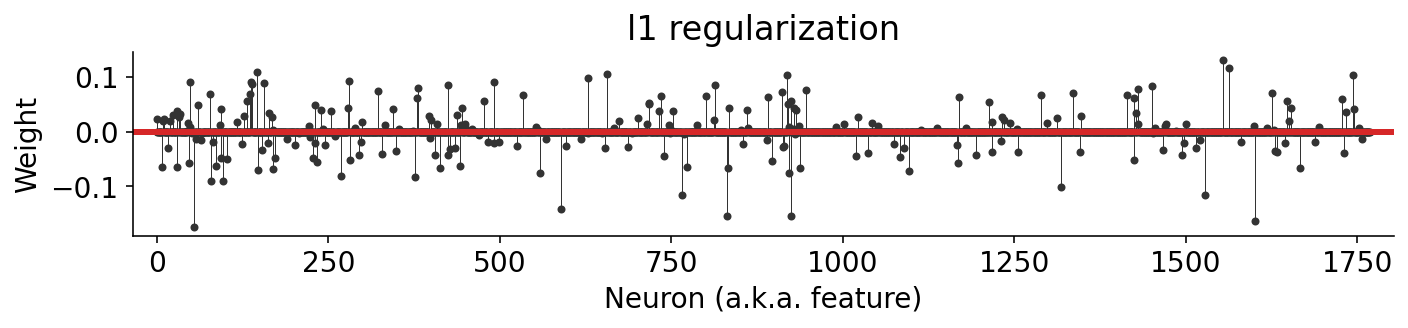

In [41]:
log_reg = LogisticRegression(penalty="l1",C=1,solver='saga',max_iter=10000)
log_reg.fit(X_TGL, y)
y_pred=log_reg.predict(X_TGL)

accuracy = (y == y_pred).mean()
print(accuracy)
plot_weights({"l1 regularization": log_reg})

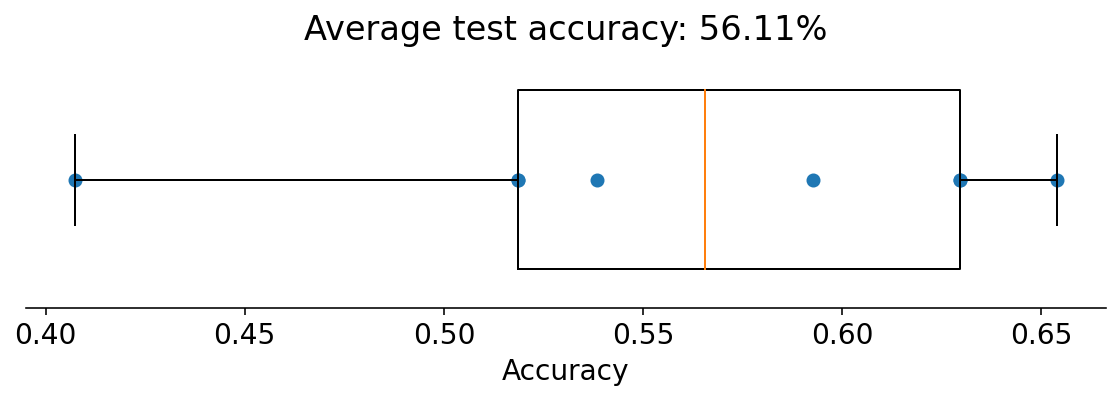

In [42]:
accuracies = cross_val_score(log_reg, X_TGL, y, cv=8)

f, ax = plt.subplots(figsize=(8, 3))
ax.boxplot(accuracies, vert=False, widths=.7)
ax.scatter(accuracies, np.ones(8))
ax.set(
  xlabel="Accuracy",
  yticks=[],
  title=f"Average test accuracy: {accuracies.mean():.2%}"
)
ax.spines["left"].set_visible(False)